# Credit card fraud detection models

## Dataset's author info

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing

In [2]:
data = pd.read_csv('creditcard.csv')

## Data analysis

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
len(data[data['Class'] == 1])/len(data)*100

0.1727485630620034

It's true that the dataset is highly unbalanced, the positive class (frauds) make only 0.173% of all transactions.

In [8]:
from sklearn.preprocessing import StandardScaler
scaled_data = data.copy()

col_names = list(data.columns.values)
col_names.pop()

features = scaled_data[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_data[col_names] = features
scaled_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


Standardization will make our SVM model faster. It is important because we have features with different ranges in dataset.|

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(scaled_data, scaled_data["Class"]):
    strat_train_set = scaled_data.loc[train_index]
    strat_test_set = scaled_data.loc[test_index]

X_train = strat_train_set.drop('Class', axis=1, inplace = False)
y_train  = strat_train_set[['Class']]

X_test = strat_test_set.drop('Class', axis=1, inplace = False)
y_test  = strat_test_set[['Class']]

In [10]:
corr_matrix = data.corr()
correlations = corr_matrix['Class'].sort_values(ascending=False).drop('Class')

Text(0.5, 1.0, 'Correlations with label column')

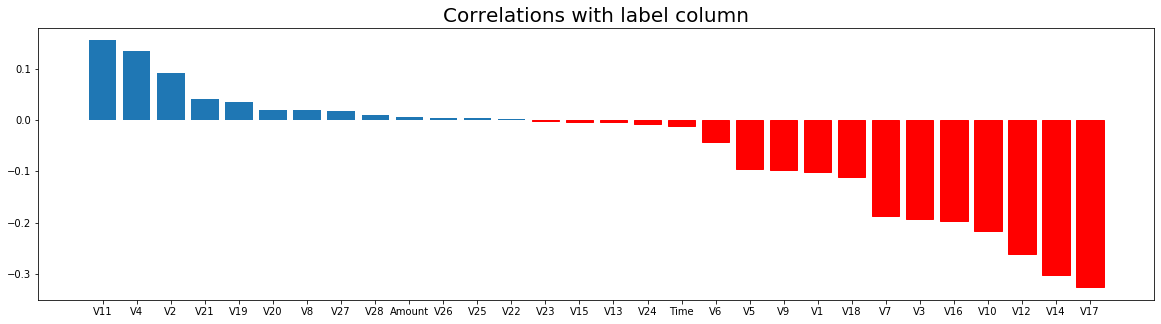

In [11]:
%matplotlib inline
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(1,1,1)
plt.bar(correlations.index, correlations)
for i in range(len(correlations)):
    if correlations[i] < 0:
        ax.get_children()[i].set_color('r') 
plt.title('Correlations with label column', fontsize=20)

In [12]:
list_of_new_columns = correlations[abs(correlations) >= abs(correlations['V23'])]
list_of_new_columns

V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64

Now we have list with enough correlated features. We will train models with all features and selected features to compare results

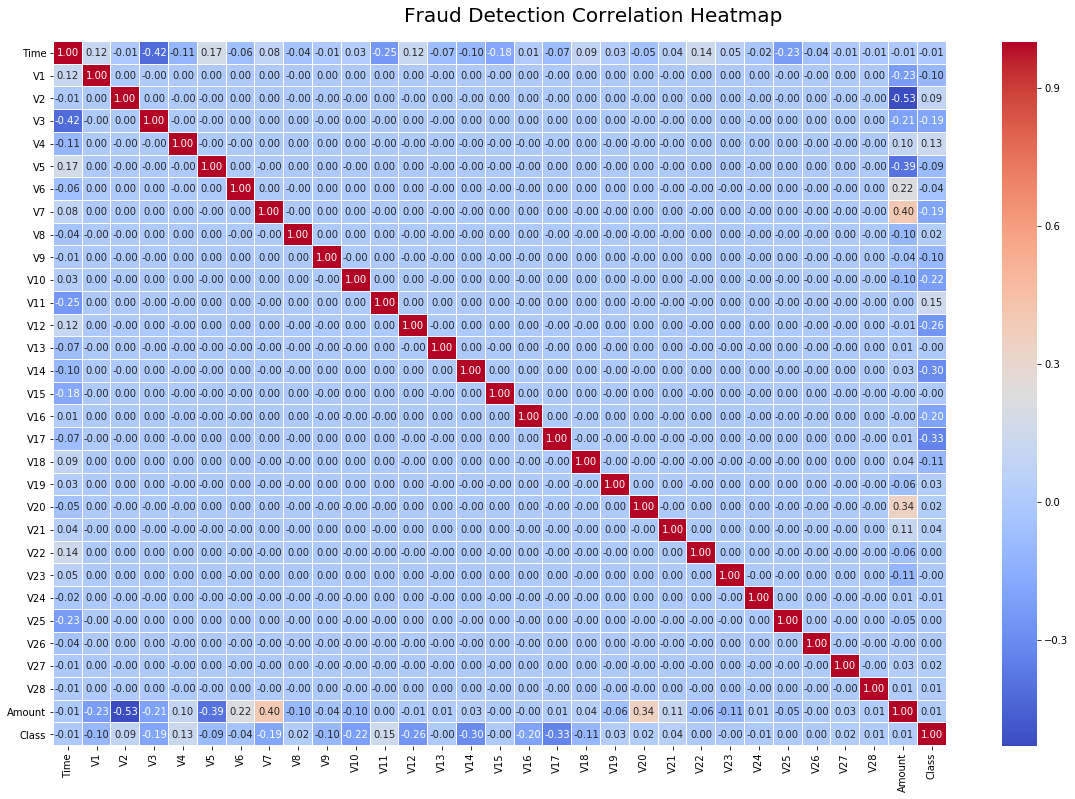

In [13]:
import seaborn as sns

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(20, 12))
hm = sns.heatmap(round(corr_matrix,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

f.subplots_adjust(top=0.94)
t= f.suptitle('Fraud Detection Correlation Heatmap', fontsize=20)

Visualization of correlation matrix could help us to understand rest of the features. For instance $V_{2}$ feature is higly correlated with $Amount$ and $V_{3}$ is highly correlated with $Time$. 

In [14]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

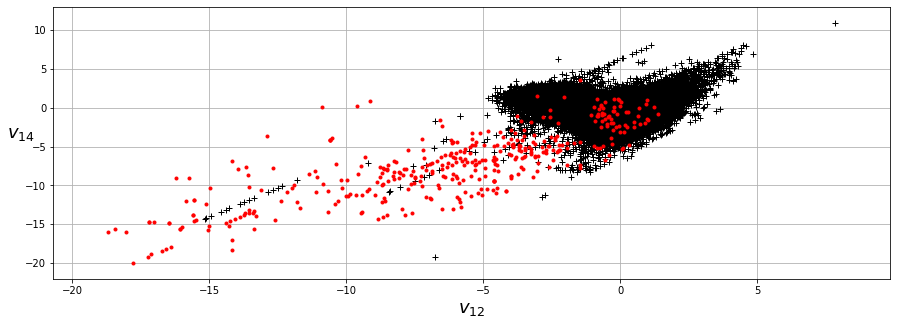

In [15]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)

index_0 = [not i for i in y_train.values]
index_1 = [not i for i in index_0]

ax.plot(X_train[['V12', 'V14']].values[index_0, 0], X_train[['V12', 'V14']].values[index_0, 1], "k+")

ax.plot(X_train[['V12', 'V14']].values[index_1, 0], X_train[['V12', 'V14']].values[index_1, 1], "r.")

ax.set_xlabel("$v_{12}$", fontsize=18)
ax.set_ylabel("$v_{14}$", fontsize=18, rotation=0)
ax.axis([min(X_train[['V12', 'V14']].values[:, 0]) - 2, max(X_train[['V12', 'V14']].values[:, 0]) + 2
         , min(X_train[['V12', 'V14']].values[:, 1]) - 2, max(X_train[['V12', 'V14']].values[:, 1]) + 2])
ax.grid(True)


2D visualization based on two most correlated with $Class$ features.

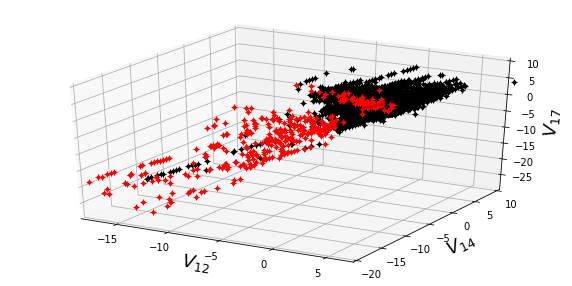

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(x1, x2, x1, alpha=0.2, color="k")

ax.plot([0], [0], [0], "k.")


ax.plot(X_train[['V12', 'V14', 'V17']].values[index_0, 0], X_train[['V12', 'V14', 'V17']].values[index_0, 1], X_train[['V12', 'V14', 'V17']].values[index_0, 2], "k+")
ax.plot(X_train[['V12', 'V14', 'V17']].values[index_0, 0], X_train[['V12', 'V14', 'V17']].values[index_0, 1], X_train[['V12', 'V14', 'V17']].values[index_0, 2], "k.")

ax.plot(X_train[['V12', 'V14', 'V17']].values[index_1, 0], X_train[['V12', 'V14', 'V17']].values[index_1, 1], X_train[['V12', 'V14', 'V17']].values[index_1, 2], "r+")
ax.plot(X_train[['V12', 'V14', 'V17']].values[index_1, 0], X_train[['V12', 'V14', 'V17']].values[index_1, 1], X_train[['V12', 'V14', 'V17']].values[index_1, 2], "r.")

ax.set_xlabel("$V_{12}$", fontsize=18)
ax.set_ylabel("$V_{14}$", fontsize=18)
ax.set_zlabel("$V_{17}$", fontsize=18)

ax.set_xlim(int(min(X_train[['V12', 'V14', 'V17']].values[:, 0])), int(max(X_train[['V12', 'V14', 'V17']].values[:, 0])))
ax.set_ylim(int(min(X_train[['V12', 'V14', 'V17']].values[:, 1])), int(max(X_train[['V12', 'V14', 'V17']].values[:, 1])))
ax.set_zlim(int(min(X_train[['V12', 'V14', 'V17']].values[:, 2])), int(max(X_train[['V12', 'V14', 'V17']].values[:, 2])))

plt.show()

3D visualization based on three most correlated with $Class$ features.

In [17]:
from imblearn.combine import SMOTEENN

smote = SMOTEENN(1/8)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train['Class'])

Combination of undersampling and oversampling. One of the most important steps in dealing with imbalanced data. We resampled data in 1:8 proportion to split it into seven independent training sets.

## Splitting training set into 8 independent sets

In [18]:
data_train = np.c_[X_train_resampled, y_train_resampled]
data_train = pd.DataFrame(data_train, columns=data.columns.values)

data_train_1 = data_train[data_train['Class'] == 1]
data_train_0 = data_train[data_train['Class'] == 0]

border = int(len(data_train_0)/8)
indices = [i*border for i in range(8)]
indices = indices + [len(data_train_0) - 1]

data_train_0_chunks = [data_train_0.iloc[indices[n]:indices[n+1]] for n in range(len(indices)-1)]

list_of_training_sets = []
col_names = list(data.columns.values)
col_names.pop()

for i in data_train_0_chunks:
    var = pd.concat([i, data_train_1])
    var_y = var['Class']
    var_X = var[col_names]
    list_of_training_sets.append([var_X, var_y])

In [19]:
X_train_1, y_train_1 = list_of_training_sets[0][0], list_of_training_sets[0][1]
X_train_2, y_train_2 = list_of_training_sets[1][0], list_of_training_sets[1][1]
X_train_3, y_train_3 = list_of_training_sets[2][0], list_of_training_sets[2][1]
X_train_4, y_train_4 = list_of_training_sets[3][0], list_of_training_sets[3][1]
X_train_5, y_train_5 = list_of_training_sets[4][0], list_of_training_sets[4][1]
X_train_6, y_train_6 = list_of_training_sets[5][0], list_of_training_sets[5][1]
X_train_7, y_train_7 = list_of_training_sets[6][0], list_of_training_sets[6][1]
X_train_8, y_train_8 = list_of_training_sets[7][0], list_of_training_sets[7][1]


## Histograms

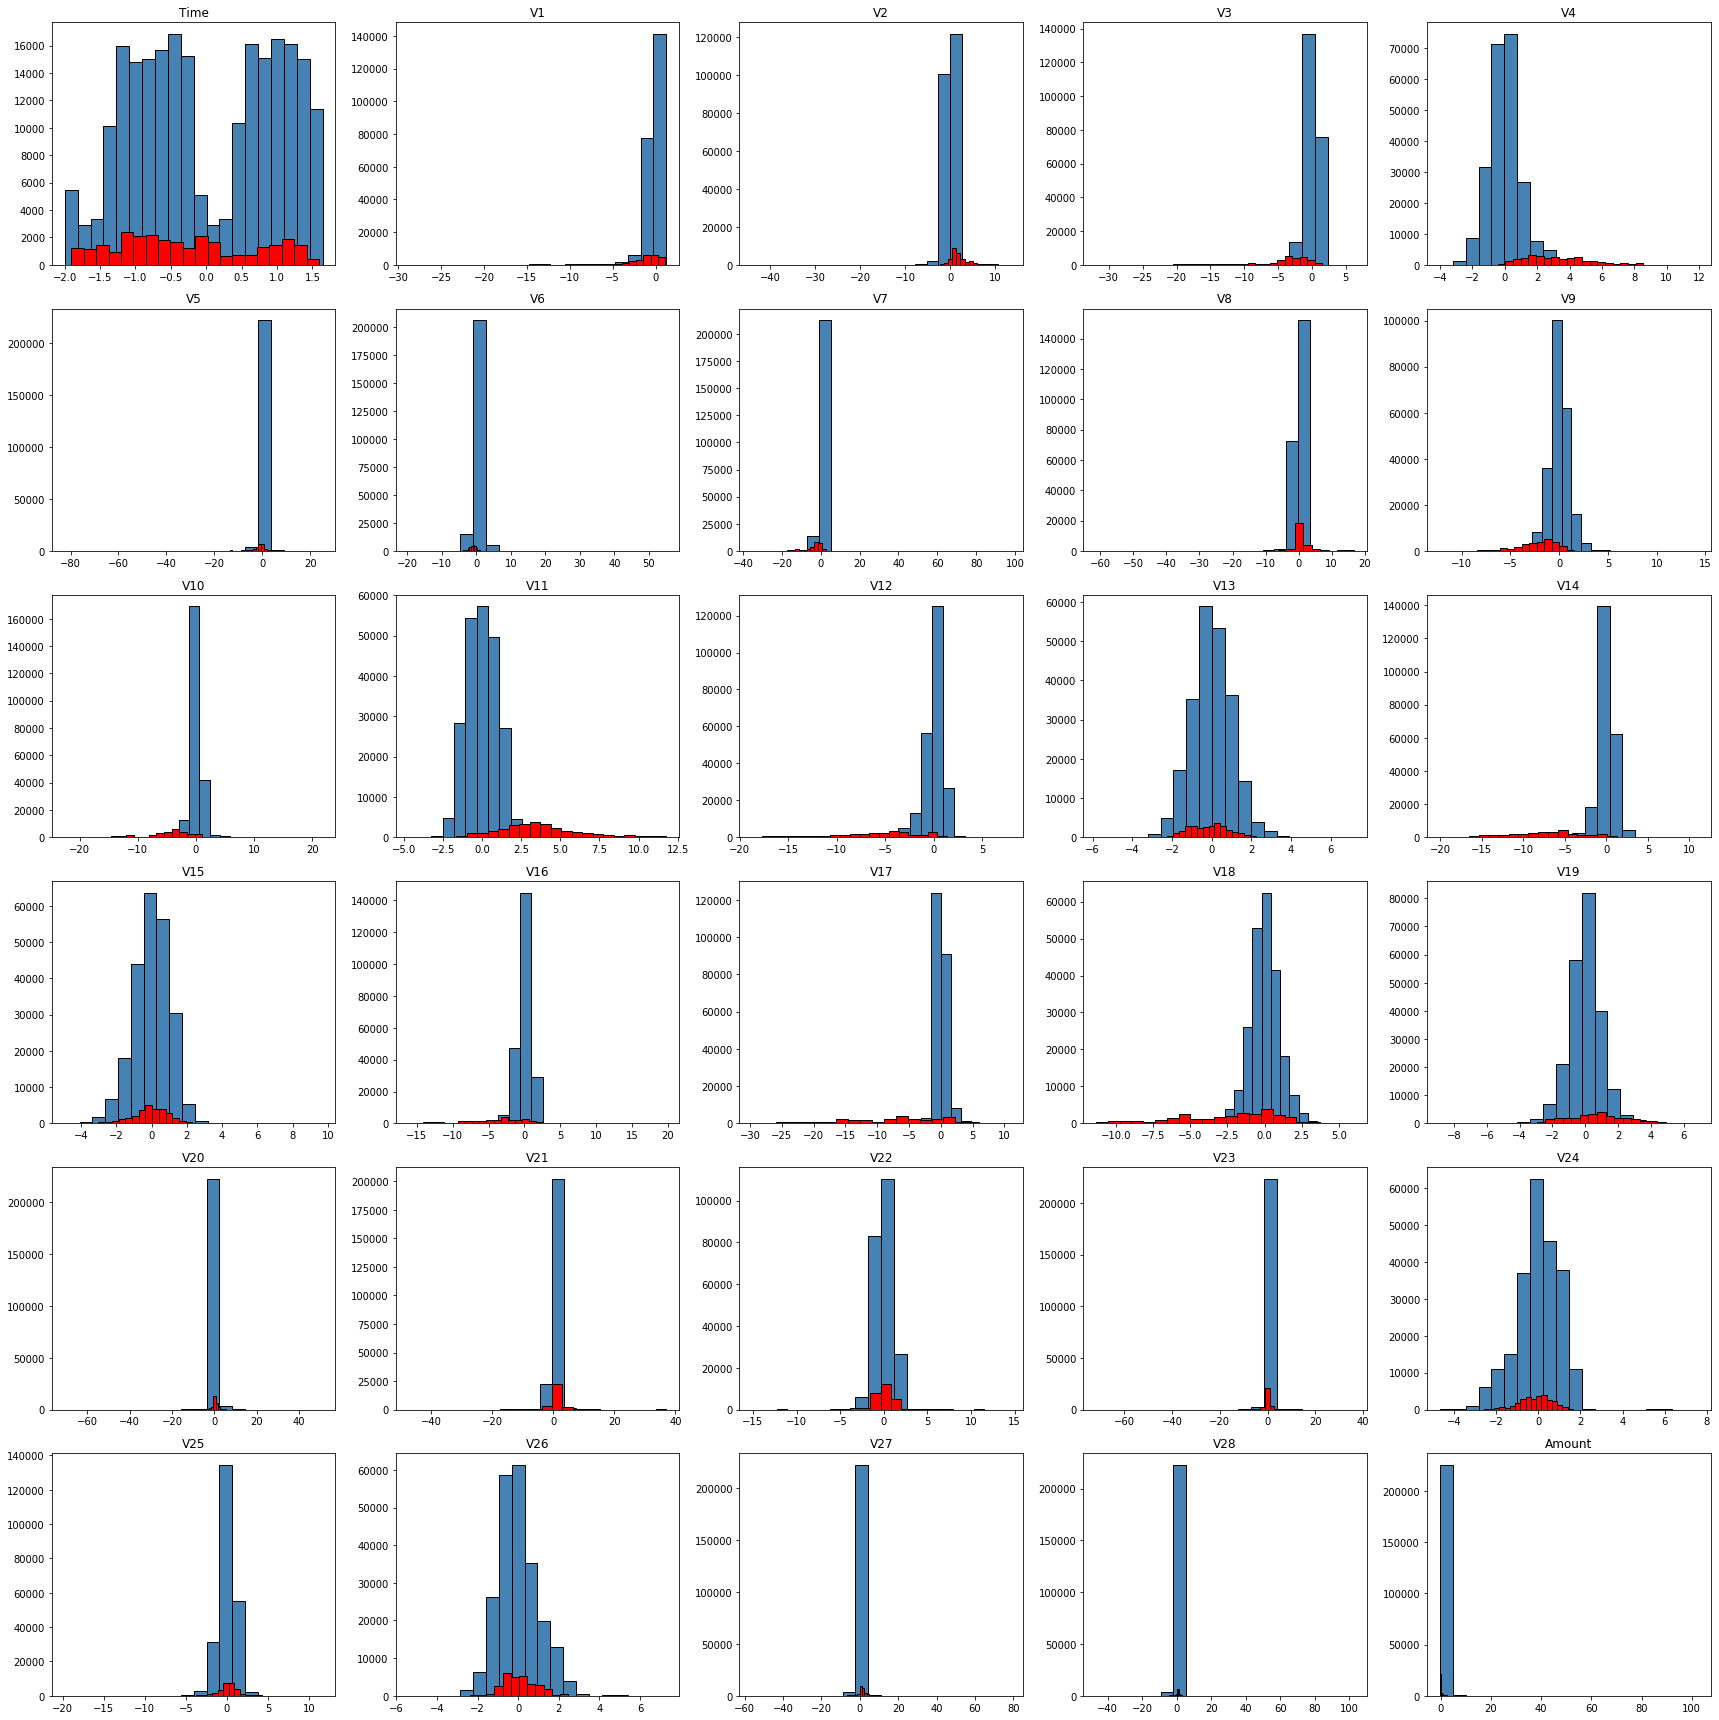

In [20]:
fig = plt.figure(figsize = (20, 20))
ax = fig.gca()

fraud_hist_data = data_train[data_train['Class'] == 1][col_names]
clients_hist_data = data_train[data_train['Class'] == 0][col_names]

for num, col in enumerate(col_names):
    plt.subplot(6, 5, num + 1)
    plt.hist(clients_hist_data[col], bins=20, color='steelblue', edgecolor='black', linewidth=1.0)  
    plt.hist(fraud_hist_data[col], bins=20, color='red', edgecolor='black', linewidth=1.0)
    plt.title(col)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

I performed histograms after resampling because before it was pretty impossible to find fraud data on bars (there was too few of them). Now we gain intuition about behaviour of fraud's instances. Coclusions are similar like in the case of correlation matrix but gives us more info about data distribution. Columns $V_{4}$,  $V_{12}$,  $V_{14}$ and  $V_{17}$ are the most significant ones.

## Preparation for comparing predicting models

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score

In [22]:
def prepare_model(clf, param_grid, X_train, y_train, list_of_selected_columns=None):
    """
    Function use GridSearch to find best model hyperparameters and decide 
    if using all columns or only the most important ones will train the 
    best model.
    
    :param clf: sklearn model with base class - BaseEstimator.
    
    :param dict param_grid: Dictionary with parameters names (string) 
    as keys and lists of parameter settings to try as values, 
    or a list of such dictionaries, in which case the grids spanned 
    by each dictionary in the list are explored. 
    This enables searching over any sequence of parameter settings.
    
    :param pandas.core.frame.DataFrame X_train: Traininig data instances.
    :param pandas.core.frame.DataFrame y_train: Labels for traininig data instances.

    :returns: 
        - imblearn.pipeline.Pipeline best -  best model after fitting the data.
        - dict grid.best_params_ - Dictionary with best params.
        - imblearn.pipeline.Pipeline grid.best_estimator_ - best model before fitting the data.
        - str all_or_selected - information whether the training on all columns was more effective 
        than the training on selected columns
    """
    
    all_or_selected = 'all'
    
    list_of_keys = list(param_grid.keys())
    for old_key in list_of_keys :
        param_grid['clf__' + old_key] = param_grid.pop(old_key)
        
    model = Pipeline([
        ('clf', clf)
    ])

    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', verbose=1)
    grid.fit(X_train, y_train)
    
    params = grid.best_params_
    estimator = grid.best_estimator_
    best = estimator.fit(X_train, y_train)
    
    if list_of_selected_columns != None:
        grid_2 = GridSearchCV(model, params, cv=3, scoring='roc_auc', verbose=1)
        grid_2.fit(X_train[list_of_selected_columns], y_train)
        
        if grid_2.best_score_ > grid.best_score_:
            params = grid_2.best_params_
            estimator = grid_2.best_estimator_
            best = estimator.fit(X_train, y_train)
            all_or_selected = 'selected'
            return best, grid.best_params_, grid.best_estimator_, all_or_selected
        
    return best, grid.best_params_, grid.best_estimator_, all_or_selected

In [23]:
def model_tests(model, X_test, y_test):
    """
    Function printing info about model performance on test set.

    :param model: sklearn model before fitting.
    :param pandas.core.frame.DataFrame: Test data instances.
    :param pandas.core.frame.DataFrame: Label for test data instances.
    
    """
    print('Best params: \t', model[1])
    print('')
    print('Best columns amount: \t', model[3])
    print('')
    predictions = model[0].predict(X_test)
    print('Precision score: \t', precision_score(y_test, predictions))
    print('Recall score: \t', recall_score(y_test, predictions))
    print('F1 score: \t', f1_score(y_test, predictions))
    print('')
    print('Roc AUC Score: \t', roc_auc_score(y_test, predictions))
    print('')
    print(classification_report(y_test, predictions, target_names=['Client', 'Fraud']))

## Training models

In [24]:
clf_logistic_regression = prepare_model(LogisticRegression(), 
                                        {'solver':['lbfgs','sag', 'saga'], 
                                         'max_iter':[1e4]}, 
                                        X_train_1, y_train_1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.6min finished


In [25]:
clf_decision_tree = prepare_model(DecisionTreeClassifier(), 
                                        {'min_samples_split':[20, 390, 1000], 
                                         'max_depth':[None, 5, 10, 20],
                                        'random_state':[12]}, 
                                        X_train_2, y_train_2)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.6min finished


In [26]:
clf_svc = prepare_model(SVC(), {'C':[1.0, 2.0], 
                                'class_weight':['balanced'],
                                'random_state':[12],
                                'gamma':['scale'],
                                'kernel':['poly', 'rbf', 'sigmoid']}, 
                                 X_train_3, y_train_3)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.9min finished


In [27]:
clf_sgd = prepare_model(SGDClassifier(), {'penalty':['l1', 'l2', 'elasticnet'],
                                'alpha':[0.0001, 0.01],
                                'random_state':[12]},
                                 X_train_4, y_train_4)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.3s finished


In [28]:
clf_gausian = prepare_model(GaussianNB(), 
                                        {'priors':[None]}, 
                                        X_train_5, y_train_5)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [29]:
clf_gradient_boosting = prepare_model(GradientBoostingClassifier(), 
                        {'learning_rate':[0.1, 0.05],
                         'max_depth':[None, 10], 'n_estimators':[100, 200],
                         'random_state':[12]}, X_train_6, y_train_6)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 35.7min finished


In [30]:
clf_random_forest = prepare_model(RandomForestClassifier(), 
                        {'max_depth':[None, 10, 15], 'n_estimators':[100, 200],
                         'random_state':[12], 'criterion':['gini','entropy']}, X_train_7, y_train_7)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 14.7min finished


## Models evaluation

### Single classifiers

In [31]:
model_tests(clf_logistic_regression, X_test, y_test)

Best params: 	 {'clf__max_iter': 10000.0, 'clf__solver': 'lbfgs'}

Best columns amount: 	 all

Precision score: 	 0.05714285714285714
Recall score: 	 0.9183673469387755
F1 score: 	 0.10759115361625822

Roc AUC Score: 	 0.9461262030135632

              precision    recall  f1-score   support

      Client       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



We could assume that dependencies between dependent and independent variables is not a linear transformation because increasing the recall score highly decreased our precision.

In [32]:
model_tests(clf_decision_tree, X_test, y_test)

Best params: 	 {'clf__max_depth': 10, 'clf__min_samples_split': 390, 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.06587301587301587
Recall score: 	 0.8469387755102041
F1 score: 	 0.12223858615611193

Roc AUC Score: 	 0.913120133393819

              precision    recall  f1-score   support

      Client       1.00      0.98      0.99     56864
       Fraud       0.07      0.85      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.91      0.56     56962
weighted avg       1.00      0.98      0.99     56962



We pay for high recall with very small precision. Probably one decision tree could not find enough complex decision boundary.

In [33]:
model_tests(clf_svc, X_test, y_test)

Best params: 	 {'clf__C': 2.0, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.07971014492753623
Recall score: 	 0.8979591836734694
F1 score: 	 0.14642262895174707

Roc AUC Score: 	 0.9400459958885073

              precision    recall  f1-score   support

      Client       1.00      0.98      0.99     56864
       Fraud       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962



For kernel: 'rbf' value depends only on the distance between the input and some fixed point. Seems that it's not enough for our data, beacause increasing recall score highly decreased precision score for fraud detections.

In [34]:
model_tests(clf_sgd, X_test, y_test)

Best params: 	 {'clf__alpha': 0.0001, 'clf__penalty': 'elasticnet', 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.049019607843137254
Recall score: 	 0.9183673469387755
F1 score: 	 0.09307135470527404

Roc AUC Score: 	 0.9438312536607214

              precision    recall  f1-score   support

      Client       1.00      0.97      0.98     56864
       Fraud       0.05      0.92      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In essence gradient descent is kind of a greedy approach. The gradient is nothing but the direction along which the loss function decreases the fastest, and descending this means finding the locally optimal choice at each iteration.There is no guarantee that the optimization algorithm will find a global minimum. If loss function is not convex function our data could be too complex to train model with high recall and sufficient precision.

In [35]:
model_tests(clf_gausian, X_test, y_test)

Best params: 	 {'clf__priors': None}

Best columns amount: 	 all

Precision score: 	 0.05620915032679739
Recall score: 	 0.8775510204081632
F1 score: 	 0.10565110565110565

Roc AUC Score: 	 0.9260785490335695

              precision    recall  f1-score   support

      Client       1.00      0.97      0.99     56864
       Fraud       0.06      0.88      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.97      0.99     56962



Naive Bayes assumes that all features are independent, so if the variables are correlated, the predictions will be weak. Our data functions are mostly PCA breakdown results, so it was obvious that this model would not be good enough.

### Ensembled classifiers

Individual models gave us a high recall, but the precision was insufficient. People don't like being disturbed, so we can't take action against users knowing that only 1 in 20 suspects are really guilty. Ensembled classifiers could be helpful in increasing our precision withou decreasing recall.

In [36]:
model_tests(clf_gradient_boosting, X_test, y_test)

Best params: 	 {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.4322916666666667
Recall score: 	 0.8469387755102041
F1 score: 	 0.5724137931034483

Roc AUC Score: 	 0.9225109606307352

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     56864
       Fraud       0.43      0.85      0.57        98

    accuracy                           1.00     56962
   macro avg       0.72      0.92      0.79     56962
weighted avg       1.00      1.00      1.00     56962



Gradient Boosting is a method, which builds on weak classifiers. The idea is to add a classifier at a time, so that the next classifier is trained to improve the already trained ensemble. In this way we increased complexity of our model, however now it has much better precision.

In [37]:
model_tests(clf_random_forest, X_test, y_test)

Best params: 	 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 200, 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.5304878048780488
Recall score: 	 0.8877551020408163
F1 score: 	 0.6641221374045801

Roc AUC Score: 	 0.9432004969967728

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     56864
       Fraud       0.53      0.89      0.66        98

    accuracy                           1.00     56962
   macro avg       0.77      0.94      0.83     56962
weighted avg       1.00      1.00      1.00     56962



Random forests outperform single decision trees because:

$\cdot$ Trees are unpruned. A random forest tree is fully grown and unpruned, what brings about the feature space is split into more and smaller regions.

$\cdot$ Trees are diverse. Each random forest tree is learned on a random sample, and at each node, a random set of features are considered for splitting. 

Both mechanisms create diversity among the trees. Unpruned and diverse trees lead to a high resolution in the feature space. For continuous features, it means a smoother decision boundary.

### Voting Classifier with evaluation

We managed to train two models with much better results than the previous ones. Now we should try to combine them into one classifier. It is highly possible that the result can give us even more satisfactory predictions.

In [38]:
voting_clf = VotingClassifier(estimators=[
    ('p1', clf_gradient_boosting[2]), 
    ('p2', clf_random_forest[2]),
    ('p3', clf_random_forest[2])
], voting='hard')

voting_clf.fit(X_train_8, y_train_8)

predictions = voting_clf.predict(X_test)
print('Precision score: \t', precision_score(y_test, predictions))
print('Recall score: \t', recall_score(y_test, predictions))
print('F1 score: \t', f1_score(y_test, predictions))
print('Roc AUC Score: \t', roc_auc_score(y_test, predictions))

print('')
print(classification_report(y_test, predictions, target_names=['Client', 'Fraud']))

Precision score: 	 0.58
Recall score: 	 0.8877551020408163
F1 score: 	 0.7016129032258065
Roc AUC Score: 	 0.9433235977283428

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     56864
       Fraud       0.58      0.89      0.70        98

    accuracy                           1.00     56962
   macro avg       0.79      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962



### Best model 

As we might expect, the best classifier was created from a combination of the two most effective predictive models in the right proportion.

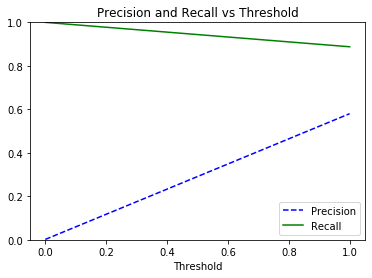

In [40]:
from sklearn.metrics import precision_recall_curve
predictions = voting_clf.predict(X_test)

precisions, recalls, thresholds = precision_recall_curve(y_test, predictions)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Function plotting precision and recall curve. The independent variables is 
    threshold nd the dependent variables are precision and recall.

    :param numpy.ndarray precisions: Array of precisions for model's predictions.
    :param numpy.ndarray recalls: Array of recalls for model's predictions.
    :param numpy.ndarray thresholds: Array of thresholds for model's predictions.
    """
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.title('Precision and Recall vs Threshold')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

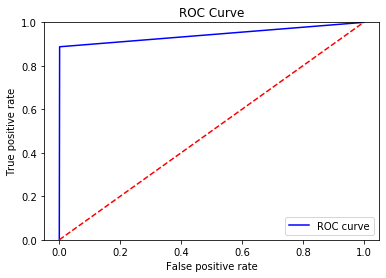

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, predictions)

def plot_roc_curve(fpr, tpr):
    """
    Function plotting ROC curve. The independent variables is 
    False positive rate and the dependent variables is True positive rate.

    :param numpy.ndarray fpr: Array of False positives rates
    :param numpy.ndarray tpr: Array of True positives rates.
    """
    
    plt.plot(fpr, tpr, "b-", label="ROC curve")
    plt.plot([0, 1], [0,1], "r--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.title('ROC Curve')
plot_roc_curve(fpr, tpr)
plt.show()